In [9]:
import netCDF4 as nc
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#from read2ADPR import readOrb
import importlib
import read2ADPR

import cmbFunctions as cmb
importlib.reload(cmb)
importlib.reload(read2ADPR) 
#print(dir(read2ADPR))
fs=glob.glob('data/2A*HDF5')
fsB=glob.glob('data/2B*HDF5')
fs=sorted(fs)
fsB=sorted(fsB)
snowTotal=[]
orbList=['44929','44842','44806','44766']
orbList=['44842']
n1,n2=0,300
import pickle
kuoNN=pickle.load(open('kuoNN.pklz','rb'))["kuoNN"]

from numba import jit
@jit(nopython=True)
def rebinZ(zMeasured):
    ns,nr,nbin,nch=zMeasured.shape
    zMeasured2=np.zeros((ns,nr,int(nbin/2),nch),float)
    for i in range(ns):
        for j in range(nr):
            zMeasured2[i,j,:,:]=np.log10(0.5*(10**(0.1*zMeasured[i,j,::2,:])+10**(0.1*zMeasured[i,j,1::2,:]))+1e-9)*10
    return zMeasured2

zKa1L=[]
zKa2L=[]
rsfc1L=[]
rsfc2L=[]
zKaN1L=[]
zKaN2L=[]
swc1tL=[]
swc2tL=[]
swc3tL=[]

for i_,f in enumerate(fs):
    try:
        sfcPrecip,hzero,pType,stormTop,bzd,zku,bcf,precipRate,lon,lat,fh=read2ADPR.readOrb(f)
        qv,press,envNodes,airTemp,skTemp,binNodes,pwc,sfcEmiss,dm,cldw,sfcBin,zCorrected,pType,lon,lat=cmb.readCMB(fsB[i_])
        with nc.Dataset(fsB[i_]) as fh:
            precipRateCMB=fh["KuKaGMI/precipTotRate"][:,:,:]
            pwcCMB=fh["KuKaGMI/precipTotWaterCont"][:,:,:]
    except:
        print("failed to read ",f)
        continue
    if i%20==0:
        print(f,fsB[i_])
    zku_coarse=rebinZ(zku)
    nsmax=binNodes.shape[0]
    dm_factor=0.9975
    nsmax=binNodes.shape[0]
    zKaSim,zkaSfc,pRateCMB,pwc=cmb.simulateZKa(binNodes[:nsmax,:,:],zCorrected[:nsmax,:,:],dm[:nsmax,:,:],dm_factor,cmb.lkTables,pType[:nsmax,:]) 
    
    swc1L=[]
    swc2L=[]
    xobsL=[]
    
    zKaSim_masked=np.ma.array(zKaSim,mask=zKaSim<0)
    zku_coarse_masked=np.ma.array(zku_coarse,mask=zku_coarse<0)
    
    for i in range(0,nsmax):
        for j in range(0,48):
            bin1=min(binNodes[i,j,1],binNodes[i,j,4])
            if pType[i,j]<1:
                continue
            a=np.nonzero(zKaSim_masked[i,j,:bin1]>0)
            b=np.nonzero(zku_coarse_masked[i,j,a[0],1]==zku_coarse_masked[i,j,a[0],1])
            if len(a[0])>0:
                #r1L.extend(precipRateCMB[i,j,a[0][b]])
                #r2L.extend(pRateCMB[i,j,a[0][b]])
                if pwc[i,j,bin1-1]>0:
                    swc1L.append(pwcCMB[i,j,bin1-1])
                    swc2L.append(pwc[i,j,bin1-1])
                    xobsL.append(zku_coarse_masked[i,j,bin1-1,:])
                    rsfc1L.append(precipRateCMB[i,j,bin1-1])
                    rsfc2L.append(pRateCMB[i,j,bin1-1])
                    zKaN1L.append(zku_coarse_masked[i,j,bin1-1,1])
                    zKaN2L.append(zKaSim_masked[i,j,bin1-1])
    if len(xobsL)>0:
        swc3L=kuoNN.predict(xobsL)
        swc1tL.extend(swc1L)
        swc2tL.extend(swc2L)
        swc3tL.extend(swc3L)
            #zKa1L.extend(zKaSim_masked[i,j,a[0][b]])
            #zKa2L.extend(zku_coarse_masked[i,j,a[0][b],1])
    #break

data/2A-CS-CONUS.GPM.DPR.V9-20211125.20220104-S042913-E043514.044608.V07A.HDF5 data/2B-CS-CONUS.GPM.DPRGMI.CORRA2022.20220104-S042913-E043514.044608.V07A.HDF5
data/2A-CS-CONUS.GPM.DPR.V9-20211125.20220105-S020227-E021104.044622.V07A.HDF5 data/2B-CS-CONUS.GPM.DPRGMI.CORRA2022.20220105-S020227-E021104.044622.V07A.HDF5
data/2A-CS-CONUS.GPM.DPR.V9-20211125.20220108-S041237-E041354.044670.V07A.HDF5 data/2B-CS-CONUS.GPM.DPRGMI.CORRA2022.20220108-S041237-E041354.044670.V07A.HDF5
data/2A-CS-CONUS.GPM.DPR.V9-20211125.20220110-S022210-E023036.044700.V07A.HDF5 data/2B-CS-CONUS.GPM.DPRGMI.CORRA2022.20220110-S022210-E023036.044700.V07A.HDF5
data/2A-CS-CONUS.GPM.DPR.V9-20211125.20220112-S071340-E071653.044734.V07A.HDF5 data/2B-CS-CONUS.GPM.DPRGMI.CORRA2022.20220112-S071340-E071653.044734.V07A.HDF5
data/2A-CS-CONUS.GPM.DPR.V9-20211125.20220113-S011943-E012822.044746.V07A.HDF5 data/2B-CS-CONUS.GPM.DPRGMI.CORRA2022.20220113-S011943-E012822.044746.V07A.HDF5
data/2A-CS-CONUS.GPM.DPR.V9-20211125.20220114-

360731 360731
0.85474324 0.9338594360591421
0.1426166 0.1550378519054098 0.3941690716764392


/Users/mgrecu/miniconda3/lib/python3.9/site-packages/xarray/core/variable.py:293: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(data)


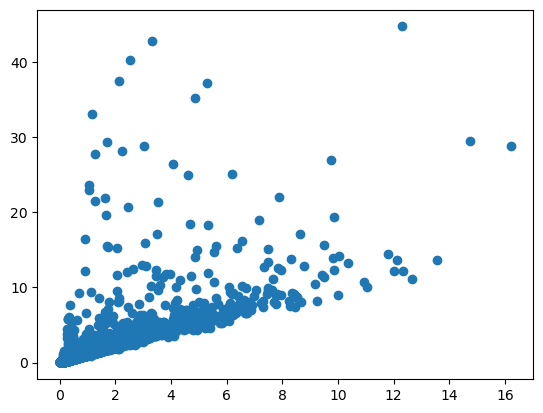

In [10]:

print(len(rsfc1L),len(rsfc2L))
print(np.mean(rsfc1L),np.mean(rsfc2L))
print(np.mean(swc1tL),np.mean(swc2tL),np.mean(swc3tL))
#print(dir(cmb.lkTables.swc))
plt.scatter(swc1tL,swc2tL)
import xarray as xr
rsfc1X=xr.DataArray(rsfc1L,dims=["n"],coords={"n":np.arange(len(rsfc1L))})
rsfc2X=xr.DataArray(rsfc2L,dims=["n"],coords={"n":np.arange(len(rsfc2L))})
swc1tX=xr.DataArray(swc1tL,dims=["n"],coords={"n":np.arange(len(swc1tL))})
swc2tX=xr.DataArray(swc2tL,dims=["n"],coords={"n":np.arange(len(swc2tL))})
swc3tX=xr.DataArray(swc3tL,dims=["n"],coords={"n":np.arange(len(swc3tL))})
zKaN1X=xr.DataArray(zKaN1L,dims=["n"],coords={"n":np.arange(len(zKaN1L))})
zKaN2X=xr.DataArray(zKaN2L,dims=["n"],coords={"n":np.arange(len(zKaN2L))})
ds=xr.Dataset({"srate_nom":rsfc1X,"srate_adj":rsfc2X,"swc_nom":swc1tX,"swc_adj":swc2tX,"swc_kuo":swc3tX,"zKa_obs":zKaN1X,"zKa_adj":zKaN2X})
#save the data to compressed file

ds.to_netcdf("swcCompare_dm09975.nc",encoding={"srate_nom":{"zlib":True,"complevel":9},"srate_adj":{"zlib":True,"complevel":9},
                                            "swc_nom":{"zlib":True,"complevel":9},"swc_adj":{"zlib":True,"complevel":9},
                                            "swc_kuo":{"zlib":True,"complevel":9},"zKa_obs":{"zlib":True,"complevel":9},
                                            "zKa_adj":{"zlib":True,"complevel":9}})


266
30033002 692 49


(88.0, 70.0)

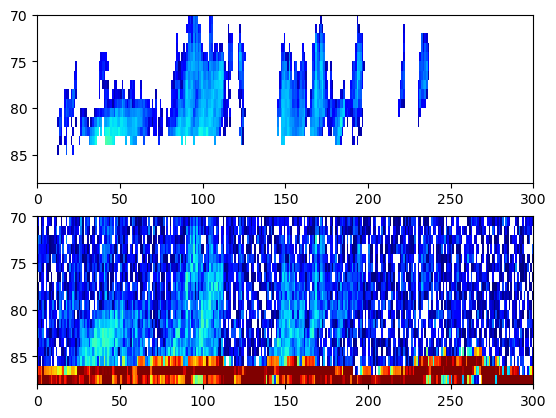

In [22]:

iplot = 0
if iplot==1:
    print(len(fs))
    plt.subplot(211)
    plt.pcolormesh(zKaSim_masked[n1:n2,24,:].T,vmin=10,vmax=40,cmap='jet')
    plt.ylim(88,70)
    plt.subplot(212)
    plt.pcolormesh(zku_coarse_masked[n1:n2,24,:,1].T,vmin=10,vmax=40,cmap='jet')
    plt.ylim(88,70)

(array([  0,   0,   0, ..., 166, 166, 166]), array([13, 13, 13, ..., 24, 24, 24]), array([79, 80, 81, ..., 74, 75, 76]))
(230, 49, 88)
(230, 49, 88)
(692, 49, 5)
[[1.         0.62664928]
 [0.62664928 1.        ]]
16.11712410351062 15.8155090284081
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'asymBB', 'asymG', 'asymR', 'asymS', 'attKaBB', 'attKaG', 'attKaR', 'attKaS', 'attKuBB', 'attKuG', 'attKuR', 'attKuS', 'dmBB', 'dmg', 'dmr', 'dms', 'fh', 'fhBB', 'graupRate', 'gwc', 'kextBB', 'kextG', 'kextR', 'kextS', 'precRateBB', 'rainRate', 'rwc', 'salbBB', 'salbG', 'salbR', 'salbS', 'snowRate', 'swc', 'zKaBB', 'zKaG', 'zKaR', 'zKaS', 'zKuBB', 'zKuG', 'zKuR', 'zKuS']


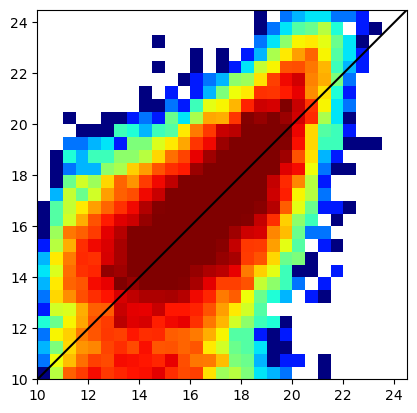

In [23]:
a=np.nonzero(zKaSim_masked[n1+70:n2,:,:]>0)
print(a)
print(zKaSim_masked[n1+70:n2,:,:].shape)
print(zku_coarse_masked[n1+70:n2,:,:,0].shape)
#plt.scatter(zKaSim_masked[n1+70:n2,:,:][a],zku_coarse_masked[n1+70:n2,:,:,0][a])
zKa1L=[]
zKa2L=[]
print(binNodes.shape)
r1L=[]
r2L=[]
swc1L=[]
swc2L=[]
xobsL=[]

plt.figure()
ax=plt.subplot(111)
plt.hist2d(zKa1L,zKa2L,bins=np.arange(10,25,0.5),cmap='jet',norm=colors.LogNorm(vmin=1,vmax=100))
ax.set_aspect('equal')
plt.plot(np.arange(10,25,0.5),np.arange(10,25,0.5),'k')
print(np.corrcoef(zKa1L,zKa2L))
print(np.mean(zKa1L),np.mean(zKa2L))
print(dir(cmb.lkTables))

In [24]:
print(np.corrcoef(r1L,r2L))
print(np.mean(r1L),np.mean(r2L))
swcKuoNN=kuoNN.predict(np.array(xobsL))
print(np.mean(swc1L),np.mean(swc2L),swcKuoNN.mean())
print(np.corrcoef(swc2L,swcKuoNN))
print(np.corrcoef(swc1L,swcKuoNN))

[[1.         0.99237281]
 [0.99237281 1.        ]]
0.5148971 0.9272367077054522
0.10172308 0.205599910097678 0.38338667869987764
[[1.         0.77741026]
 [0.77741026 1.        ]]
[[1.         0.77971992]
 [0.77971992 1.        ]]
